This notebook was meant to produce useful plot figures for a report.

For this notebook to work, downloading the OGGM version available at : https://github.com/lucillegimenes/oggm is necessary. 

In [379]:
# %%

import oggm
import time
import timeit
import nc_time_axis
from oggm import cfg, utils, workflow, tasks, graphics, global_tasks
from oggm.core import flowline, massbalance
import salem
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import functools
from oggm.shop import gcm_climate

cfg.initialize(logging_level='WARNING')

cfg.PARAMS['use_multiprocessing']=True
cfg.PATHS['working_dir'] = '/home/gimenelu/Run_oggm_fig/'
cfg.PARAMS['continue_on_error'] = True

2023-09-15 13:31:56: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-09-15 13:31:56: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-09-15 13:31:56: oggm.cfg: Multiprocessing: using all available processors (N=16)
2023-09-15 13:31:56: oggm.cfg: Multiprocessing switched ON after user settings.
2023-09-15 13:31:56: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


In [130]:

#Working with GLACIOCLIM glaciers
rgi_ids=["RGI60-11.03638","RGI60-11.03671","RGI60-11.03643","RGI60-11.03674","RGI60-11.03756", #Argentière, Gébroulaz, Mer de Glace,St-Sorlin, Sarennes
    "RGI60-16.00543","RGI60-16.01339", #Zongo, Antizana
    "RGI60-11.03232", #Ossoue
    "RGI60-15.03591"] #Mera


"""
#Working with a larger set of glaciers
rgi_ids=["RGI60-11.03638","RGI60-11.03671","RGI60-11.03643","RGI60-11.03674","RGI60-11.03756", #Argentière, Gébroulaz, Mer de Glace,St-Sorlin, Sarennes
    "RGI60-16.00543","RGI60-16.01339", #Zongo, Antizana
    "RGI60-11.03232", #Ossoue
    "RGI60-11.03646", #Bossons
    "RGI60-15.03591", #Mera
    "RGI60-15.03733", #Khumbu
    "RGI60-14.07524", #Siachen
    "RGI60-13.54431", #Fedtchenko
    "RGI60-01.05355", #Alexander
    "RGI60-01.13696"] #Malaspina
"""


base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_spinup/'
gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=5, prepro_base_url=base_url,prepro_border=160)

2023-09-14 16:28:24: oggm.workflow: init_glacier_directories from prepro level 5 on 9 glaciers.
2023-09-14 16:28:24: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 9 glaciers


# Simulations from GCM data

In [131]:
#Processing climate data
user ='gimenelu'
m='MRI-ESM2-0'
ssp='ssp126'

fp = '/mnt/{}/equipes/CRYODYN/OGGM/CMIP6-2300/{}_{}_r1i1p1f1_pr.nc'.format(user,m,ssp)
ft = '/mnt/{}/equipes/CRYODYN/OGGM/CMIP6-2300/{}_{}_r1i1p1f1_tas.nc'.format(user,m,ssp)

#Bias correction of the files
workflow.execute_entity_task(gcm_climate.process_cmip_data, gdirs, 
                                         filesuffix='_CMIP6_{}_{}'.format(m,ssp),  # recognize the climate file for later
                                         fpath_temp=ft,  # temperature projections
                                         fpath_precip=fp,  # precip projections
                                         );
cfg.PARAMS['use_multiprocessing']=False

2023-09-14 16:28:28: oggm.workflow: Execute entity tasks [process_cmip_data] on 9 glaciers
2023-09-14 16:28:53: oggm.cfg: Multiprocessing switched OFF after user settings.


In [132]:
#Running the simulation and keeping track of running time
num_mod = ['SemiImplicit','FluxBased','SIA1D']
num_mod_perf = {'SemiImplicit':[0]*2,'FluxBased':[0]*2,'SIA1D':[0]*2}
samples = 20

for n in num_mod :
    cfg.PARAMS["evolution_model"] = n  

    
    time_perf=[]
    for t in range(0,samples):
    
        tic = time.perf_counter()
        workflow.execute_entity_task(tasks.run_from_climate_data,gdirs,ys=2020,
                                                 climate_filename='gcm_data',
                                                 climate_input_filesuffix='_CMIP6_{}_{}'.format(m,ssp),
                                                 init_model_filesuffix='_spinup_historical',
                                                 output_filesuffix='_{}'.format(n))
        toc = time.perf_counter()
        time_perf.append(toc-tic)
        
    num_mod_perf[n][0]= np.mean(time_perf)
    num_mod_perf[n][1]= np.std(time_perf)

2023-09-14 16:29:34: oggm.workflow: Execute entity tasks [run_from_climate_data] on 9 glaciers
2023-09-14 16:29:34: oggm.workflow: WARNING: you are trying to run an entity task on 9 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2023-09-14 16:29:39: oggm.workflow: Execute entity tasks [run_from_climate_data] on 9 glaciers
2023-09-14 16:29:39: oggm.workflow: WARNING: you are trying to run an entity task on 9 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2023-09-14 16:29:43: oggm.workflow: Execute entity tasks [run_from_climate_data] on 9 glaciers
2023-09-14 16:29:43: oggm.workflow: WARNING: you are trying to run an entity task on 9 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2023-09-14 16:29:48: oggm.workflow: Execute entity tasks [run_from_climate_data] on 9 glaciers
2023-09-14 16:29:48: oggm.workflow: WARNING: you are trying to run an enti

2023-09-14 16:32:12: oggm.workflow: WARNING: you are trying to run an entity task on 9 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2023-09-14 16:32:20: oggm.workflow: Execute entity tasks [run_from_climate_data] on 9 glaciers
2023-09-14 16:32:20: oggm.workflow: WARNING: you are trying to run an entity task on 9 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2023-09-14 16:32:28: oggm.workflow: Execute entity tasks [run_from_climate_data] on 9 glaciers
2023-09-14 16:32:28: oggm.workflow: WARNING: you are trying to run an entity task on 9 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2023-09-14 16:32:36: oggm.workflow: Execute entity tasks [run_from_climate_data] on 9 glaciers
2023-09-14 16:32:36: oggm.workflow: WARNING: you are trying to run an entity task on 9 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessin

2023-09-14 16:34:49: oggm.workflow: Execute entity tasks [run_from_climate_data] on 9 glaciers
2023-09-14 16:34:49: oggm.workflow: WARNING: you are trying to run an entity task on 9 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.


In [133]:
cfg.add_to_basenames('gcm_data_CMIP6_{}_{}'.format(m,ssp),'gcm_data_CMIP6_{}_{}.nc'.format(m,ssp))

In [134]:
#Little adjustment with climate date times to plot the climate later
climat=[]
pix_elev = []
for gdir in gdirs :
    with xr.open_dataset(gdir.get_filepath('gcm_data_CMIP6_{}_{}'.format(m,ssp))) as dh:
        dh = dh.load()
        
    dh.coords['rgi_id'] = gdir.rgi_id # add rgi as a coordinate
    dh.coords['rgi_id'].attrs['description'] = 'glacier RGI ID'  # add a description
    dh = dh.expand_dims("rgi_id")  # add GCM as a dimension to all Data variables
    climat.append(dh)
    pix_elev.append(dh.attrs['ref_hgt'])
    

ds_merged= xr.combine_by_coords(climat, fill_value=np.nan, combine_attrs='override')
ds_tmp = ds_merged.mean(dim='rgi_id').to_dataframe()
per=pd.period_range("1850-01-01", "2300-12-01", freq="M")
per=pd.PeriodIndex(per.values, freq="M")


ds_tmp['time'] = per 
ds_tmp2 = ds_tmp.set_index('time')
ds_tmp2= ds_tmp2.resample('A',convention='start').mean()
        
xr_tmp = ds_tmp2.to_xarray()
        
tt = xr_tmp.time.values.astype('M8[Y]').astype('float64')+1970
xr_tmp['time'] = tt
print(np.mean(pix_elev))

2458.5555555555557


/home/gimenelu/anaconda3/envs/my_oggm_env/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/gimenelu/anaconda3/envs/my_oggm_env/lib/python3.11/site-packages/xarray/core/indexing.py:556: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/home/gimenelu/anaconda3/envs/my_oggm_env/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/gimenelu/anaconda3/envs/m

### Plotting results

2023-09-14 16:40:09: oggm.utils: Applying global task compile_run_output on 9 glaciers
2023-09-14 16:40:09: oggm.utils: Applying compile_run_output on 9 gdirs.
2023-09-14 16:40:10: oggm.utils: Applying global task compile_run_output on 9 glaciers
2023-09-14 16:40:10: oggm.utils: Applying compile_run_output on 9 gdirs.
2023-09-14 16:40:10: oggm.utils: Applying global task compile_run_output on 9 glaciers
2023-09-14 16:40:10: oggm.utils: Applying compile_run_output on 9 gdirs.


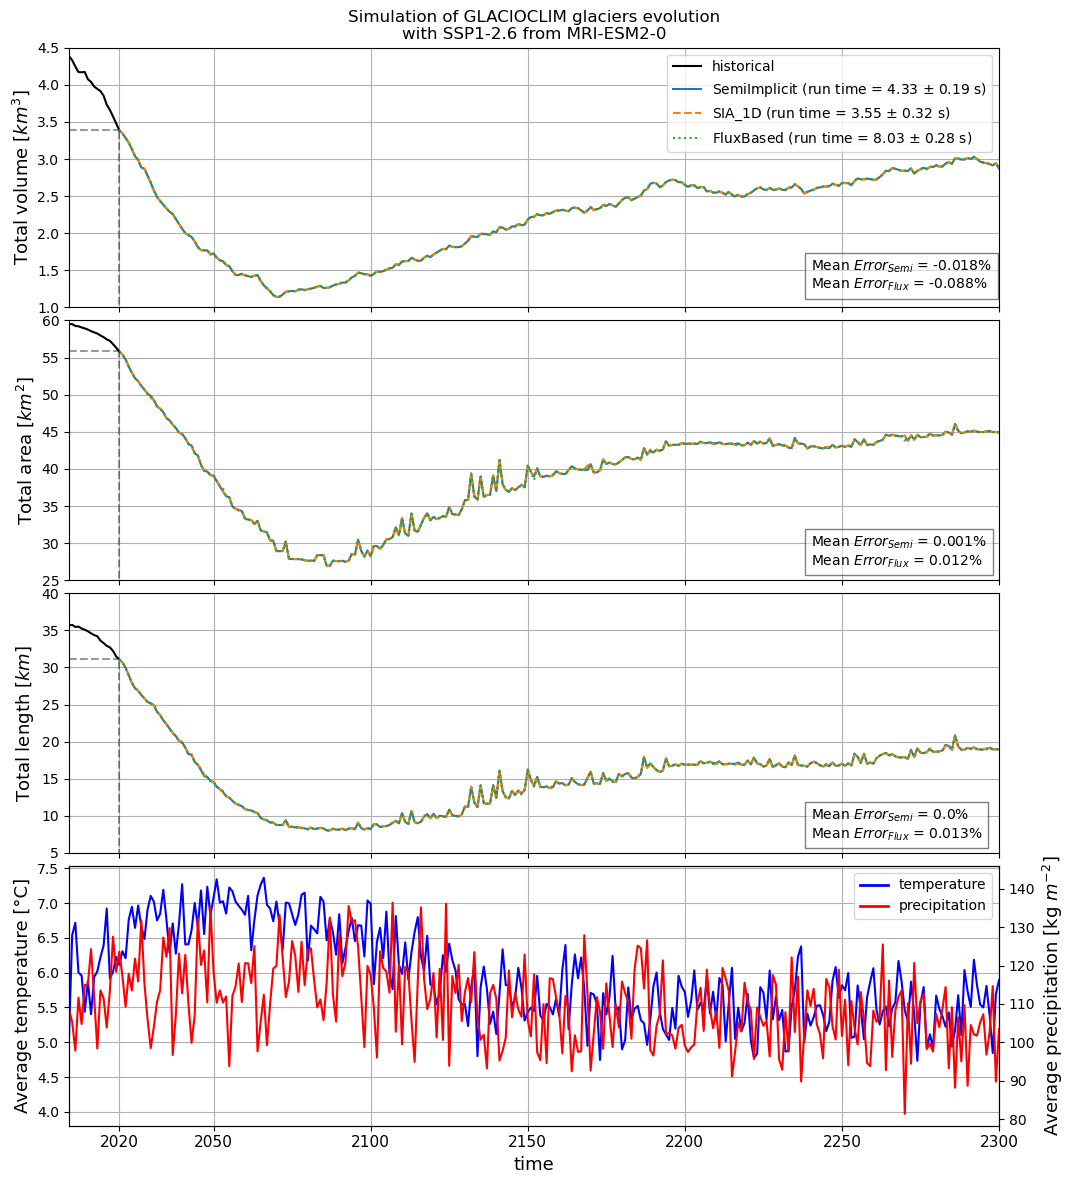

In [135]:
from matplotlib.lines import Line2D
#Plotting the results 

f, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(12, 14),sharex=True)
f.subplots_adjust(hspace=0.05)
handles, labels = plt.gca().get_legend_handles_labels()

#PROJECTION RUN VARIABLES
ds = utils.compile_run_output(gdirs, input_filesuffix='_SemiImplicit')
ds2 = utils.compile_run_output(gdirs, input_filesuffix='_SIA1D')
ds3 = utils.compile_run_output(gdirs, input_filesuffix='_FluxBased')


#HISTORICAL VARIABLES
dhist_tot = []
for gdir in gdirs :
    with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix='_spinup_historical')) as dhist:
        dhist = dhist.load()
        
    dhist.coords['rgi_id'] = gdir.rgi_id # add rgi as a coordinate
    dhist.coords['rgi_id'].attrs['description'] = 'glacier RGI ID'  # add a description
    dhist = dhist.expand_dims("rgi_id")  # add GCM as a dimension to all Data variables
    dhist_tot.append(dhist)
    
dhist_merged= xr.combine_by_coords(dhist_tot, fill_value=np.nan, combine_attrs='override')
ax1.plot(dhist.time.values,dhist_merged.sum(dim='rgi_id').volume_m3.values*10**(-9),color='k', label = 'historical')
ax2.plot(dhist.time.values,dhist_merged.sum(dim='rgi_id').area_m2.values*10**(-6),color='k')
ax3.plot(dhist.time.values,dhist_merged.sum(dim='rgi_id').length_m.values*10**(-3),color='k')

handles, labels = plt.gca().get_legend_handles_labels()  

#### VOLUME 
(ds.sum(dim='rgi_id').volume*1e-9).plot(ax=ax1,
label="SemiImplicit (run time = {} $\pm$ {} s)".format(round(num_mod_perf['SemiImplicit'][0],2),
                                                      round(num_mod_perf['SemiImplicit'][1],2)))
(ds2.sum(dim='rgi_id').volume*1e-9).plot(ax=ax1,linestyle="dashed",
                label="SIA_1D (run time = {} $\pm$ {} s)".format(round(num_mod_perf['SIA1D'][0],2),
                                                                round(num_mod_perf['SIA1D'][1],2)))
(ds3.sum(dim='rgi_id').volume*1e-9).plot(ax=ax1,linestyle=":",
                label="FluxBased (run time = {} $\pm$ {} s)".format(round(num_mod_perf['FluxBased'][0],2),
                                                          round(num_mod_perf['FluxBased'][1],2)))


err_s = round(((ds2.sum(dim='rgi_id').volume-ds.sum(dim='rgi_id').volume)/ds.sum(dim='rgi_id').volume).mean().data*100,3)
err_f = round(((ds2.sum(dim='rgi_id').volume-ds3.sum(dim='rgi_id').volume)/ds3.sum(dim='rgi_id').volume).mean().data*100,3)
test='$Error_{Semi}$'
test2='$Error_{Flux}$'
ax1.text(2240, 1.25, 'Mean {} = {}% \nMean {} = {}%'.format(test,err_s,test2,err_f),
         fontsize = 10,bbox=dict(facecolor='white', alpha=0.5))
ax1.vlines(x = 2020,ymin=0,ymax=dhist_merged.sum(dim='rgi_id').volume_m3[-1].values*10**(-9),
           color = 'k',linestyle='dashed',alpha=0.4)

ax1.hlines(y = dhist_merged.sum(dim='rgi_id').volume_m3[-1].values*10**(-9),xmin=2004,xmax=2020,
           color = 'k',linestyle='dashed',alpha=0.4)

ax1.set_ylim([1,4.5])



#### AREA
(ds.sum(dim='rgi_id').area*1e-6).plot(ax=ax2)
(ds2.sum(dim='rgi_id').area*1e-6).plot(ax=ax2,linestyle='dashed')
(ds3.sum(dim='rgi_id').area*1e-6).plot(ax=ax2,linestyle=':')

err_s = round(((ds2.sum(dim='rgi_id').area-ds.sum(dim='rgi_id').area)/ds.sum(dim='rgi_id').area).mean().data*100,3)
err_f = round(((ds2.sum(dim='rgi_id').area-ds3.sum(dim='rgi_id').area)/ds3.sum(dim='rgi_id').area).mean().data*100,3)
test='$Error_{Semi}$'
test2='$Error_{Flux}$'
ax2.text(2240, 27, 'Mean {} = {}% \nMean {} = {}%'.format(test,err_s,test2,err_f),
         fontsize = 10,bbox=dict(facecolor='white', alpha=0.5))

ax2.vlines(x = 2020,ymin=0,ymax=dhist_merged.sum(dim='rgi_id').area_m2[-1].values*10**(-6),
           color = 'k',linestyle='dashed',alpha=0.4)

ax2.hlines(y = dhist_merged.sum(dim='rgi_id').area_m2[-1].values*10**(-6),xmin=2004,xmax=2020,
           color = 'k',linestyle='dashed',alpha=0.4)
ax2.set_ylim([25,60])



#### LENGTH
(ds.sum(dim='rgi_id').length*1e-3).plot(ax=ax3)
(ds2.sum(dim='rgi_id').length*1e-3).plot(ax=ax3,linestyle="dashed")
(ds3.sum(dim='rgi_id').length*1e-3).plot(ax=ax3,linestyle=':')

err_s = round(((ds2.sum(dim='rgi_id').length-ds.sum(dim='rgi_id').length)/ds.sum(dim='rgi_id').length).mean().data*100,3)
err_f = round(((ds2.sum(dim='rgi_id').length-ds3.sum(dim='rgi_id').length)/ds3.sum(dim='rgi_id').length).mean().data*100,3)
test='$Error_{Semi}$'
test2='$Error_{Flux}$'
ax3.text(2240, 7, 'Mean {} = {}% \nMean {} = {}%'.format(test,err_s,test2,err_f),
         fontsize = 10,bbox=dict(facecolor='white', alpha=0.5))

ax3.vlines(x = 2020,ymin=0,ymax=dhist_merged.sum(dim='rgi_id').length_m[-1].values*10**(-3),
           color = 'k',linestyle='dashed',alpha=0.4)

ax3.hlines(y = dhist_merged.sum(dim='rgi_id').length_m[-1].values*10**(-3),xmin=2004,xmax=2020,
           color = 'k',linestyle='dashed',alpha=0.4)
ax3.set_ylim([5,40])



ax1.grid()
ax1.set_ylabel('Total volume [$km^3$]', fontsize = 13)
ax1.set_xlabel('')
ax2.grid()
ax2.set_ylabel('Total area [$km^2$]', fontsize = 13)
ax2.set_xlabel('')
ax2.set_title('')
ax3.grid()
ax3.set_ylabel('Total length [$km$]', fontsize = 13)
ax3.set_title('')
ax1.legend(loc=1)
ax3.set_xlabel('')

ax1.set_title('Simulation of GLACIOCLIM glaciers evolution\nwith SSP1-2.6 from MRI-ESM2-0')
ax4.set_xlabel('Time', fontsize = 13)
ax4.grid()
xr_tmp.temp.plot(ax=ax4, color='b', label = 'temperature')
ax4.set_ylabel('Average temperature [°C]', fontsize = 13)
               
ax4b=ax4.twinx()
xr_tmp.prcp.plot(ax=ax4b, color='r', label ='precipitations')
ax4b.set_ylabel('Average precipitation [kg $m^{-2}$]', fontsize=13)
ax4.set_xlim([2004,2300])
ax4.set_xticks([2020,2050,2100,2150,2200,2250,2300])
ax4.set_xticklabels(labels=['2020','2050','2100','2150','2200','2250','2300'],fontsize=11)

tl = Line2D([0], [0], color='b', lw=2, label = 'temperature')
pl = Line2D([0], [0], color='r', lw=2, label = 'precipitation')

ax4.legend(handles=[tl,pl]) 

In [136]:
#Running the simulation and keeping track of running time
cfg.PARAMS['store_model_geometry']=True
num_mod = ['SemiImplicit','FluxBased','SIA1D']
num_mod_perf = {'SemiImplicit':[0]*2,'FluxBased':[0]*2,'SIA1D':[0]*2}
samples = 20

for n in num_mod :
    cfg.PARAMS["evolution_model"] = n  

    
    time_perf=[]
    for t in range(0,samples):
    
        tic = time.perf_counter()
        workflow.execute_entity_task(tasks.run_with_hydro,gdirs,run_task=tasks.run_from_climate_data,ys=2020,
                                                 climate_filename='gcm_data',
                                                 climate_input_filesuffix='_CMIP6_{}_{}'.format(m,ssp),
                                                 init_model_filesuffix='_spinup_historical',
                                                 output_filesuffix='_{}'.format(n),store_monthly_hydro=True)
        toc = time.perf_counter()
        time_perf.append(toc-tic)
        
    num_mod_perf[n][0]= np.mean(time_perf)
    num_mod_perf[n][1]= np.std(time_perf)

2023-09-14 16:40:44: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.
2023-09-14 16:40:44: oggm.cfg: PARAMS['evolution_model'] changed from `SIA1D` to `SemiImplicit`.
2023-09-14 16:40:44: oggm.workflow: Execute entity tasks [run_with_hydro] on 9 glaciers
2023-09-14 16:40:44: oggm.workflow: WARNING: you are trying to run an entity task on 9 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2023-09-14 16:40:52: oggm.workflow: Execute entity tasks [run_with_hydro] on 9 glaciers
2023-09-14 16:40:52: oggm.workflow: WARNING: you are trying to run an entity task on 9 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2023-09-14 16:41:00: oggm.workflow: Execute entity tasks [run_with_hydro] on 9 glaciers
2023-09-14 16:41:00: oggm.workflow: WARNING: you are trying to run an entity task on 9 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.

2023-09-14 16:45:28: oggm.workflow: WARNING: you are trying to run an entity task on 9 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2023-09-14 16:45:40: oggm.workflow: Execute entity tasks [run_with_hydro] on 9 glaciers
2023-09-14 16:45:40: oggm.workflow: WARNING: you are trying to run an entity task on 9 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2023-09-14 16:45:55: oggm.workflow: Execute entity tasks [run_with_hydro] on 9 glaciers
2023-09-14 16:45:55: oggm.workflow: WARNING: you are trying to run an entity task on 9 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2023-09-14 16:46:10: oggm.workflow: Execute entity tasks [run_with_hydro] on 9 glaciers
2023-09-14 16:46:10: oggm.workflow: WARNING: you are trying to run an entity task on 9 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2023-09-

2023-09-14 16:50:52: oggm.workflow: WARNING: you are trying to run an entity task on 9 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.


2023-09-14 16:51:52: oggm.utils: Applying global task compile_run_output on 9 glaciers
2023-09-14 16:51:52: oggm.utils: Applying compile_run_output on 9 gdirs.
2023-09-14 16:51:53: oggm.utils: Applying global task compile_run_output on 9 glaciers
2023-09-14 16:51:53: oggm.utils: Applying compile_run_output on 9 gdirs.
2023-09-14 16:51:53: oggm.utils: Applying global task compile_run_output on 9 glaciers
2023-09-14 16:51:53: oggm.utils: Applying compile_run_output on 9 gdirs.


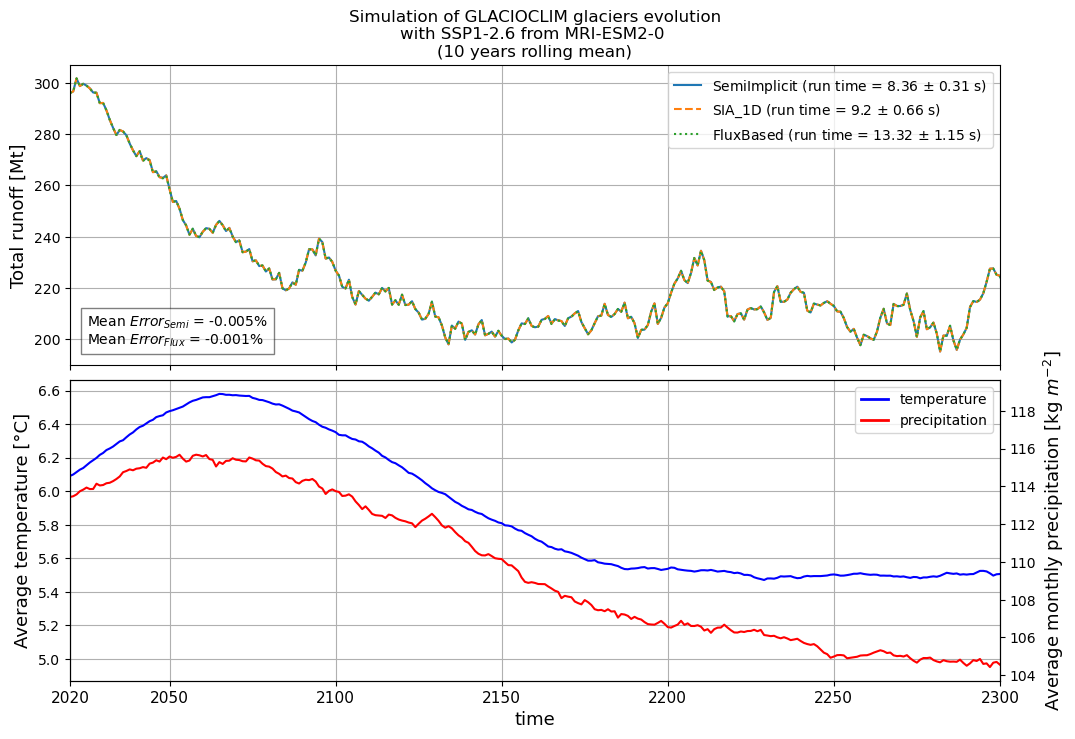

In [137]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8),sharex=True)
f.subplots_adjust(hspace=0.05)
handles, labels = plt.gca().get_legend_handles_labels()

ds = utils.compile_run_output(gdirs, input_filesuffix='_SemiImplicit')
ds2 = utils.compile_run_output(gdirs, input_filesuffix='_SIA1D')
ds3 = utils.compile_run_output(gdirs, input_filesuffix='_FluxBased')


#### RUNOFF
runoff_vars = ['melt_off_glacier', 'melt_on_glacier','liq_prcp_off_glacier', 'liq_prcp_on_glacier']     
ds_runoff = ds[runoff_vars].clip(0) * 1e-9 #convert to Mt
ds_runoff['runoff_Mt']=ds_runoff['melt_on_glacier']+ds_runoff['melt_off_glacier']+ds_runoff['liq_prcp_off_glacier']+ds_runoff['liq_prcp_on_glacier']
ds_runoff['runoff_Mt']=ds_runoff['runoff_Mt'].rolling(time=10,center=True,min_periods=1).mean()

ds2_runoff = ds2[runoff_vars].clip(0) * 1e-9 #convert to Mt
ds2_runoff['runoff_Mt']=ds2_runoff['melt_on_glacier']+ds2_runoff['melt_off_glacier']+ds2_runoff['liq_prcp_off_glacier']+ds2_runoff['liq_prcp_on_glacier']
ds2_runoff['runoff_Mt']=ds2_runoff['runoff_Mt'].rolling(time=10,center=True,min_periods=1).mean()

ds3_runoff = ds3[runoff_vars].clip(0) * 1e-9 #convert to Mt
ds3_runoff['runoff_Mt']=ds3_runoff['melt_on_glacier']+ds3_runoff['melt_off_glacier']+ds3_runoff['liq_prcp_off_glacier']+ds3_runoff['liq_prcp_on_glacier']
ds3_runoff['runoff_Mt']=ds3_runoff['runoff_Mt'].rolling(time=10,center=True,min_periods=1).mean()


(ds_runoff.sum(dim='rgi_id').runoff_Mt).plot(ax=ax1,
label="SemiImplicit (run time = {} $\pm$ {} s)".format(round(num_mod_perf['SemiImplicit'][0],2),
                                                      round(num_mod_perf['SemiImplicit'][1],2)))
(ds2_runoff.sum(dim='rgi_id').runoff_Mt).plot(ax=ax1,linestyle="dashed",
                label="SIA_1D (run time = {} $\pm$ {} s)".format(round(num_mod_perf['SIA1D'][0],2),
                                                                round(num_mod_perf['SIA1D'][1],2)))
(ds3_runoff.sum(dim='rgi_id').runoff_Mt).plot(ax=ax1,linestyle=":",
                label="FluxBased (run time = {} $\pm$ {} s)".format(round(num_mod_perf['FluxBased'][0],2),
                                                          round(num_mod_perf['FluxBased'][1],2)))


err_s = round(((ds2_runoff.sum(dim='rgi_id').runoff_Mt-ds_runoff.sum(dim='rgi_id').runoff_Mt)/ds_runoff.sum(dim='rgi_id').runoff_Mt).mean().data*100,3)
err_f = round(((ds2_runoff.sum(dim='rgi_id').runoff_Mt-ds3_runoff.sum(dim='rgi_id').runoff_Mt)/ds3_runoff.sum(dim='rgi_id').runoff_Mt).mean().data*100,3)
test='$Error_{Semi}$'
test2='$Error_{Flux}$'
ax1.text(2025, 198, 'Mean {} = {}% \nMean {} = {}%'.format(test,err_s,test2,err_f),
         fontsize = 10,bbox=dict(facecolor='white', alpha=0.5))




ax1.grid()
ax1.set_ylabel('Total runoff [Mt]', fontsize = 13)
ax1.set_xlabel('')
ax1.legend()
ax2.grid()

ax1.set_title('Simulation of GLACIOCLIM glaciers evolution\nwith SSP1-2.6 from MRI-ESM2-0 \n(10 years rolling mean)')
ax2.set_xlabel('Time', fontsize = 13)

xr_tmp.temp.rolling(time=120,center=True,min_periods=1).mean().plot(ax=ax2, color='b', label = 'temperature')
ax2.set_ylabel('Average temperature [°C]', fontsize = 13)
               
ax2b=ax2.twinx()
xr_tmp.prcp.rolling(time=120,center=True,min_periods=1).mean().plot(ax=ax2b, color='r', label ='precipitations')
ax2b.set_ylabel('Average monthly precipitation [kg $m^{-2}$]', fontsize=13)
ax2.set_xlim([2020,2300])
ax2.set_xticks([2020,2050,2100,2150,2200,2250,2300])
ax2.set_xticklabels(labels=['2020','2050','2100','2150','2200','2250','2300'],fontsize=11)

tl = Line2D([0], [0], color='b', lw=2, label = 'temperature')
pl = Line2D([0], [0], color='r', lw=2, label = 'precipitation')
ax2.legend(handles=[tl,pl]) 

# Experimenting with climate

## Sinus variations

In [27]:
#adding the name of the future climate files first time running the notebook
cfg.add_to_basenames('exp_sinus','exp_sinus.nc')

In [380]:
#Only doing the experiment on a small nb of glaciers
rgi_ids=["RGI60-11.03638",
    "RGI60-15.03733", #Khumbu
    "RGI60-13.54431", #Fedtchenko
    "RGI60-01.13696"] #Malaspina

cfg.PARAMS['use_multiprocessing'] = True

base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_spinup/'
gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=4, prepro_base_url=base_url,
                                         prepro_border=160)

2023-09-15 13:32:08: oggm.workflow: init_glacier_directories from prepro level 4 on 4 glaciers.
2023-09-15 13:32:08: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 4 glaciers


In [403]:
#creating an appropriate climate for each glacier
ds_exp_list = []
time_xr = xr.cftime_range(start="1000", periods=12000, freq="MS")
x = np.linspace(1,len(time_xr),len(time_xr))
for gdir in gdirs : 

    with xr.open_dataset(gdir.get_filepath('climate_historical')) as ex:
        ex = ex.load()
        
    dict_attrs = ex.attrs
    dict_attrs['yr_0']=1000
    dict_attrs['yr_1']=1999
    
    mu_t = ex.temp.mean().values
    sigma_t = ex.temp.std().values

    temp =sigma_t*(np.sin(x*np.pi/1200) +np.random.rand(len(x))) + mu_t
    
    mu = ex.prcp.mean().values / 8
    sigma = ex.prcp.std().values / 4
    prcp = abs(sigma * np.random.randn(len(x)) + mu)
    
    
    ds_exp = xr.Dataset(
    data_vars=dict(
        temp=(["time"], temp),
        prcp=(["time"], prcp),
    ),
    coords=dict(
        time=time_xr,
    ),
    attrs=dict_attrs)
    
    path = cfg.PATHS['working_dir']+'per_glacier/'+gdir.rgi_id[:8]+'/'+gdir.rgi_id[:11]+'/'+gdir.rgi_id+'/exp_sinus.nc'
    
    #saving the exp climate data file
    ds_exp.to_netcdf(path)
    
    ds_exp.coords['rgi_id'] = gdir.rgi_id # add rgi as a coordinate
    ds_exp.coords['rgi_id'].attrs['description'] = 'glacier RGI ID'  # add a description
    ds_exp = ds_exp.expand_dims("rgi_id")
    ds_exp_list.append(ds_exp)
    

In [404]:
ds_exp_merged = xr.combine_by_coords(ds_exp_list, fill_value=np.nan, combine_attrs='override')
ds_tmp = ds_exp_merged.mean(dim='rgi_id')

In [405]:
#Small adjustements with dates for plotting results later
ds_exp_tmp = ds_exp.to_dataframe().droplevel(0, axis=0)
date = ds_exp_tmp.index.values.astype('M8[M]').astype(str)
date_final = []
for d in date:
    y = int(d[:4])
    m = int(d[-2:])
    new_date = utils.date_to_floatyear(y,m)
    date_final.append(new_date)


In [414]:
#Running the simulation and keeping track of running time
num_mod = ['SemiImplicit','FluxBased','SIA1D']
num_mod_perf = {'SemiImplicit':[0]*2,'FluxBased':[0]*2,'SIA1D':[0]*2}
samples = 20
cfg.PARAMS['use_multiprocessing'] = False

for n in num_mod :
    cfg.PARAMS["evolution_model"] = n  

    
    time_perf=[]
    for t in range(0,samples):
    
        tic = time.perf_counter()
        workflow.execute_entity_task(tasks.run_from_climate_data,gdirs[2],ys=1000,
                                                 climate_filename='exp_sinus',
                                                 init_model_filesuffix='_spinup_historical',
                                                 output_filesuffix='_{}'.format(n),
                                                store_fl_diagnostics=True)
        toc = time.perf_counter()
        time_perf.append(toc-tic)
        
    num_mod_perf[n][0]= np.mean(time_perf)
    num_mod_perf[n][1]= np.std(time_perf)

2023-09-15 14:03:18: oggm.cfg: PARAMS['evolution_model'] changed from `SIA1D` to `SemiImplicit`.
2023-09-15 14:03:18: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-09-15 14:03:21: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-09-15 14:03:24: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-09-15 14:03:26: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-09-15 14:03:29: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-09-15 14:03:31: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-09-15 14:03:34: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-09-15 14:03:36: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-09-15 14:03:38: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-09-15 14:03:40: oggm.workflow: Execute enti

### Just taking a look a glacier profile

In [297]:
with xr.open_dataset(gdir.get_filepath('fl_diagnostics',filesuffix='_SemiImplicit'),group="fl_0") as flj:
    flj = flj.load()


(0.0, 200.0)

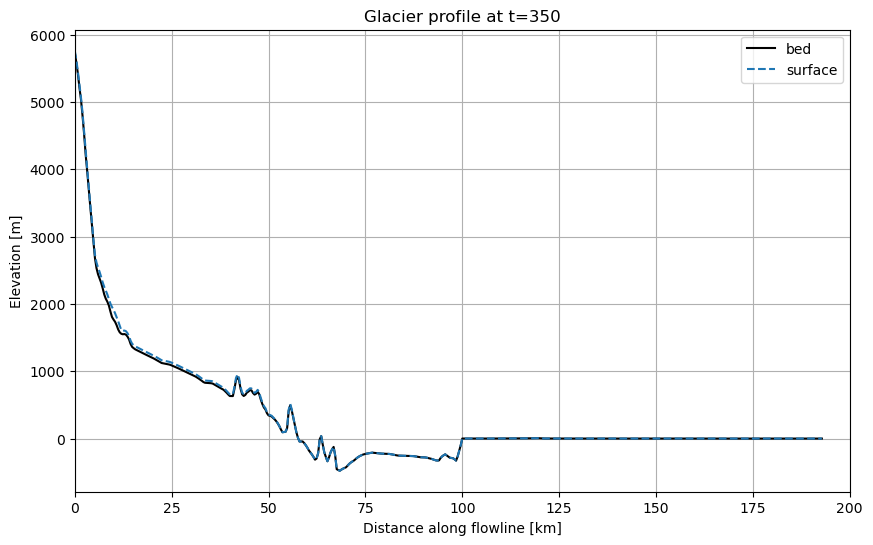

In [327]:
f= plt.subplots(figsize=(10, 6))


plt.plot(flj.dis_along_flowline*1e-3,flj.bed_h,label='bed',color='k')
plt.plot(flj.dis_along_flowline*1e-3,flj.bed_h + flj.isel(time=350).thickness_m ,label='surface', linestyle='dashed')


plt.ylabel('Elevation [m]')
plt.xlabel('Distance along flowline [km]')
plt.title('Glacier profile at t=350')

plt.grid()
plt.legend()
plt.xlim([0,200])

### Plotting results

2023-09-15 14:06:55: oggm.utils: Applying global task compile_run_output on 1 glaciers
2023-09-15 14:06:55: oggm.utils: Applying compile_run_output on 1 gdirs.
2023-09-15 14:06:55: oggm.utils: Applying global task compile_run_output on 1 glaciers
2023-09-15 14:06:55: oggm.utils: Applying compile_run_output on 1 gdirs.
2023-09-15 14:06:55: oggm.utils: Applying global task compile_run_output on 1 glaciers
2023-09-15 14:06:55: oggm.utils: Applying compile_run_output on 1 gdirs.
/tmp/ipykernel_14180/631685524.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(['0','200','400','600','800','1000'])


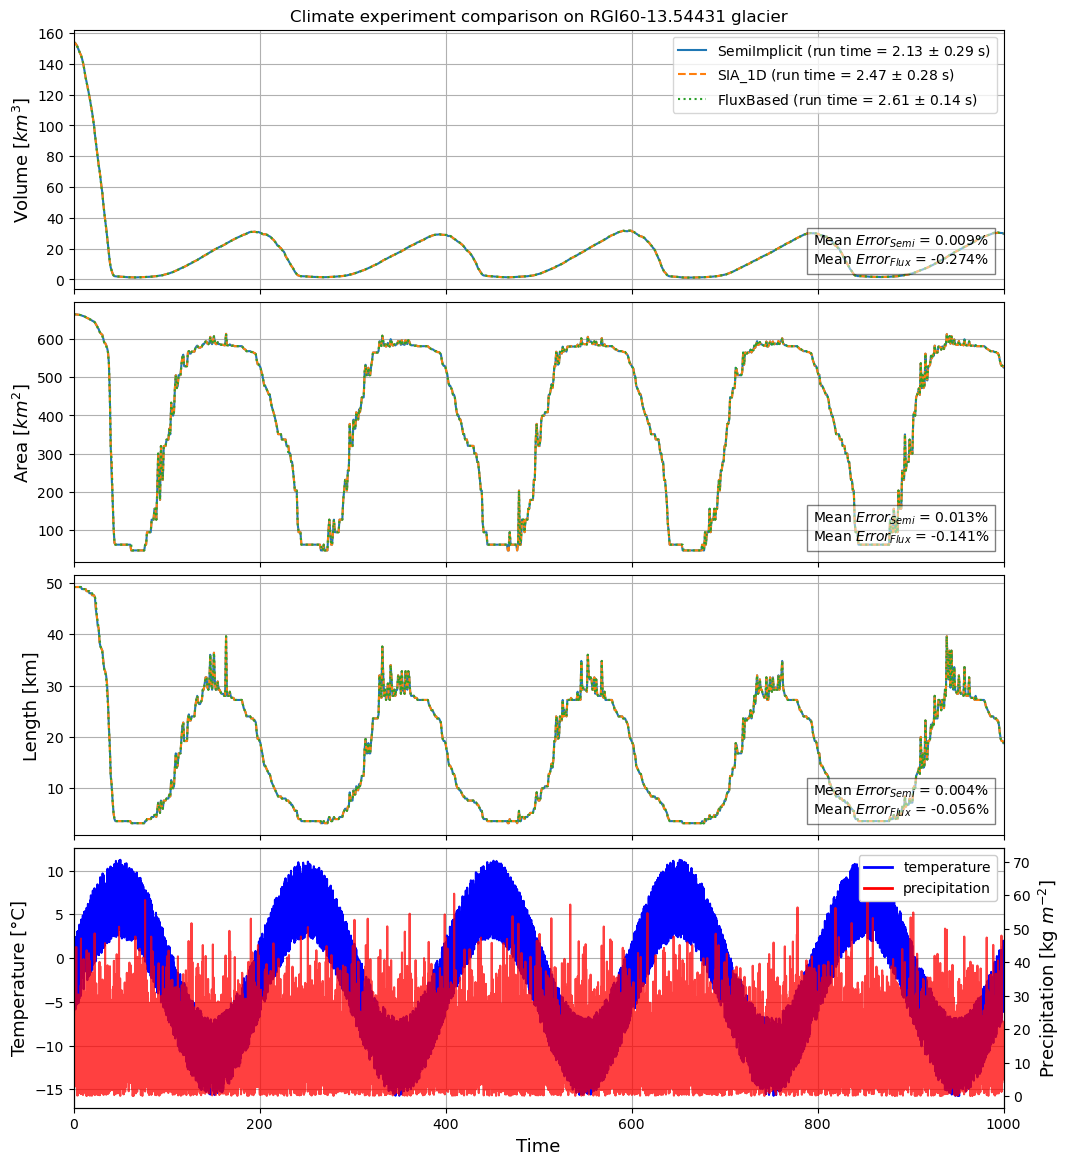

In [416]:
#Individual figure
from matplotlib.lines import Line2D
f, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(12, 14),sharex=True)
f.subplots_adjust(hspace=0.05)
gdir = gdirs[2]

"""
#Getting the minimal elevation (it is not in the diagnostic variables)
diag = []
for n in num_mod : 
    with xr.open_dataset(gdir.get_filepath('fl_diagnostics',filesuffix='_{}'.format(n)),group="fl_0") as fls:
        fls = fls.load()
    elev_length=[]
    for t in range(0,1001):
        
        tmp = fls.isel(time=t)
        ind_tmp = np.where(tmp.thickness_m==0)[0][0]
        elev = float(tmp.bed_h[ind_tmp].values)
        elev_length.append(elev)
    diag.append(elev_length)
"""
    
ds = utils.compile_run_output(gdir, input_filesuffix='_SemiImplicit')
ds2 = utils.compile_run_output(gdir, input_filesuffix='_SIA1D')
ds3 = utils.compile_run_output(gdir, input_filesuffix='_FluxBased')

(ds.volume*1e-9).plot(ax=ax1,
label="SemiImplicit (run time = {} $\pm$ {} s)".format(round(num_mod_perf['SemiImplicit'][0],2),
                                                      round(num_mod_perf['SemiImplicit'][1],2)))   


                      
(ds2.volume*1e-9).plot(ax=ax1,linestyle="dashed",
 label="SIA_1D (run time = {} $\pm$ {} s)".format(round(num_mod_perf['SIA1D'][0],2),
                                                                round(num_mod_perf['SIA1D'][1],2)))


(ds3.volume*1e-9).plot(ax=ax1,linestyle=":",
label="FluxBased (run time = {} $\pm$ {} s)".format(round(num_mod_perf['FluxBased'][0],2),
                                                          round(num_mod_perf['FluxBased'][1],2)))
err_s = round(((ds2.volume-ds.volume)/ds.volume).mean().data*100,3)
err_f = round(((ds2.volume-ds3.volume)/ds3.volume).mean().data*100,3)
test='$Error_{Semi}$'
test2='$Error_{Flux}$'
ax1.text(1795,10, 'Mean {} = {}% \nMean {} = {}%'.format(test,err_s,test2,err_f),
         fontsize = 10,bbox=dict(facecolor='white', alpha=0.5))


(ds.area*1e-6).plot(ax=ax2)
(ds2.area*1e-6).plot(ax=ax2,linestyle='dashed')
(ds3.area*1e-6).plot(ax=ax2,linestyle=':')
err_s = round(((ds2.area-ds.area)/ds.area).mean().data*100,3)
err_f = round(((ds2.area-ds3.area)/ds3.area).mean().data*100,3)
test='$Error_{Semi}$'
test2='$Error_{Flux}$'
ax2.text(1795, 70, 'Mean {} = {}% \nMean {} = {}%'.format(test,err_s,test2,err_f),
         fontsize = 10,bbox=dict(facecolor='white', alpha=0.5))

"""
ax3.plot(ds.time.values,diag[0])
ax3.plot(ds.time.values,diag[2], linestyle='dashed')
ax3.plot(ds.time.values,diag[1], linestyle=':')

err_s = round(((np.array(diag[2])-np.array(diag[0]))/np.array(diag[0])).mean()*100,3)
err_f = round(((np.array(diag[2])-np.array(diag[1]))/np.array(diag[1])).mean()*100,3)
test='$Error_{Semi}$'
test2='$Error_{Flux}$'
ax3.text(1795, -300, 'Mean {} = {}% \nMean {} = {}%'.format(test,err_s,test2,err_f),
         fontsize = 10,bbox=dict(facecolor='white', alpha=0.5))
"""


(ds.length*1e-3).plot(ax=ax3)
(ds2.length*1e-3).plot(ax=ax3,linestyle='dashed')
(ds3.length*1e-3).plot(ax=ax3,linestyle=':')
err_s = round(((ds2.length-ds.length)/ds.length).mean().data*100,3)
err_f = round(((ds2.length-ds3.length)/ds3.length).mean().data*100,3)
test='$Error_{Semi}$'
test2='$Error_{Flux}$'
ax3.text(1795, 5, 'Mean {} = {}% \nMean {} = {}%'.format(test,err_s,test2,err_f),
         fontsize = 10,bbox=dict(facecolor='white', alpha=0.5))

ax1.grid()
ax1.set_ylabel('Volume [$km^3$]',fontsize = 13)
ax1.set_xlabel('')
ax2.grid()
ax2.set_ylabel('Area [$km^2$]',fontsize = 13)
ax2.set_xlabel('')
ax2.set_title('')
ax3.grid()
#ax3.set_ylabel('Minimal elevation [m]',fontsize = 13)
ax3.set_ylabel('Length [km]',fontsize = 13)
ax3.set_title('')
ax1.legend(loc=1)
ax3.set_xlabel('')
#ax1.set_xlim([2020,2100])
ax1.set_title('Climate experiment comparison on {} glacier'.format(gdir.rgi_id)) #RGI60-01.13696
ax4.set_xlabel('Time',fontsize = 13)
ax4.set_xticklabels(['0','200','400','600','800','1000'])
ax4.grid()
ax4.plot(date_final,ds_exp_list[2].temp.values[0],color='b')
ax4.set_ylabel('Temperature [°C]',fontsize = 13)
               
ax4b=ax4.twinx()
ax4b.plot(date_final,ds_exp_list[2].prcp.values[0], color='r',alpha=0.75)
ax4b.set_ylabel('Precipitation [kg $m^{-2}$]',fontsize = 13)
ax4.set_xlim([1000,2000])
tl = Line2D([0], [0], color='b', lw=2, label = 'temperature')
pl = Line2D([0], [0], color='r', lw=2, label = 'precipitation')

ax4b.legend(handles=[tl,pl], loc = 1, framealpha=1) 

## 'Step' climate

In [ ]:
#adding the name of the future climate files first time running the notebook
cfg.add_to_basenames('exp_step','exp_step.nc')

In [447]:
#creating an appropriate climate for each glacier
ds_exp_list = []
time_xr = xr.cftime_range(start="1000", periods=12000, freq="MS")
x = np.linspace(1,len(time_xr),len(time_xr))
for gdir in gdirs : 

    with xr.open_dataset(gdir.get_filepath('climate_historical')) as ex:
        ex = ex.load()
        
    dict_attrs = ex.attrs
    dict_attrs['yr_0']=1000
    dict_attrs['yr_1']=1999
    
    mu_t = ex.temp.mean().values
    print(mu_t)
    sigma_t = ex.temp.std().values
    
    
    #rising step for glacier with negative mean temperature :
    #temp = (mu_t*0.5)*np.ones(len(x))
    #temp[6000:]=  (mu_t*0.5*0.75)*np.ones(len(x[6000:]))
    
    #rising step for glacier with positive negative mean temperature
    #temp = (mu_t*1.5)*np.ones(len(x))
    #temp[6000:]=  (mu_t*1.5*1.75)*np.ones(len(x[6000:]))
    
    #dropping step for glacier with positive mean temperature
    #temp = (mu_t*1.5)*np.ones(len(x))
    #temp[6000:]=  (mu_t*1.5*0.75)*np.ones(len(x[6000:]))
    
    #dropping step for glacier with negative mean temperature :
    temp = (mu_t*0.5)*np.ones(len(x))
    temp[6000:]=  (mu_t*0.5*1.75)*np.ones(len(x[6000:]))
    
    
    mu = ex.prcp.mean().values / 8 
    sigma = ex.prcp.std().values / 4
    prcp = abs(sigma * np.random.randn(len(x)) + mu)
    
    
    ds_exp = xr.Dataset(
    data_vars=dict(
        temp=(["time"], temp),
        prcp=(["time"], prcp),
    ),
    coords=dict(
        time=time_xr,
    ),
    attrs=dict_attrs)
    
    path = cfg.PATHS['working_dir']+'per_glacier/'+gdir.rgi_id[:8]+'/'+gdir.rgi_id[:11]+'/'+gdir.rgi_id+'/exp_step.nc'
    
    #saving the climate data file into each glacier directory
    ds_exp.to_netcdf(path)
    
    ds_exp.coords['rgi_id'] = gdir.rgi_id # add rgi as a coordinate
    ds_exp.coords['rgi_id'].attrs['description'] = 'glacier RGI ID'  # add a description
    ds_exp = ds_exp.expand_dims("rgi_id")
    ds_exp_list.append(ds_exp)
    

2.8126416
0.7478181
-6.781185
-5.9717455


In [448]:
ds_exp_merged = xr.combine_by_coords(ds_exp_list, fill_value=np.nan, combine_attrs='override')
ds_tmp = ds_exp_merged.mean(dim='rgi_id')

In [452]:
cfg.PARAMS['use_multiprocessing'] = False

#Running the simulation and keeping track of running time
num_mod = ['SemiImplicit','FluxBased','SIA1D']
num_mod_perf = {'SemiImplicit':[0]*2,'FluxBased':[0]*2,'SIA1D':[0]*2}
samples = 20

for n in num_mod :
    cfg.PARAMS["evolution_model"] = n  

    
    time_perf=[]
    for t in range(0,samples):
    
        tic = time.perf_counter()
        workflow.execute_entity_task(tasks.run_from_climate_data,gdirs[3],ys=1000,
                                                 climate_filename='exp_step',
                                                 init_model_filesuffix='_spinup_historical',
                                                 output_filesuffix='_{}'.format(n),
                                                    store_fl_diagnostics=True)
        toc = time.perf_counter()
        time_perf.append(toc-tic)
        
    num_mod_perf[n][0]= np.mean(time_perf)
    num_mod_perf[n][1]= np.std(time_perf)

2023-09-15 15:50:35: oggm.cfg: PARAMS['evolution_model'] changed from `SIA1D` to `SemiImplicit`.
2023-09-15 15:50:35: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-09-15 15:51:00: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-09-15 15:51:25: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-09-15 15:51:51: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-09-15 15:52:16: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-09-15 15:52:41: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-09-15 15:53:05: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-09-15 15:53:30: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-09-15 15:53:55: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-09-15 15:54:19: oggm.workflow: Execute enti

### Plotting results

2023-09-15 16:32:11: oggm.utils: Applying global task compile_run_output on 1 glaciers
2023-09-15 16:32:11: oggm.utils: Applying compile_run_output on 1 gdirs.
2023-09-15 16:32:11: oggm.utils: Applying global task compile_run_output on 1 glaciers
2023-09-15 16:32:11: oggm.utils: Applying compile_run_output on 1 gdirs.
2023-09-15 16:32:11: oggm.utils: Applying global task compile_run_output on 1 glaciers
2023-09-15 16:32:11: oggm.utils: Applying compile_run_output on 1 gdirs.
/tmp/ipykernel_14180/284197859.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(['0','200','400','600','800','1000'])


[Text(1000.0, 0, '0'),
 Text(1200.0, 0, '200'),
 Text(1400.0, 0, '400'),
 Text(1600.0, 0, '600'),
 Text(1800.0, 0, '800'),
 Text(2000.0, 0, '1000')]

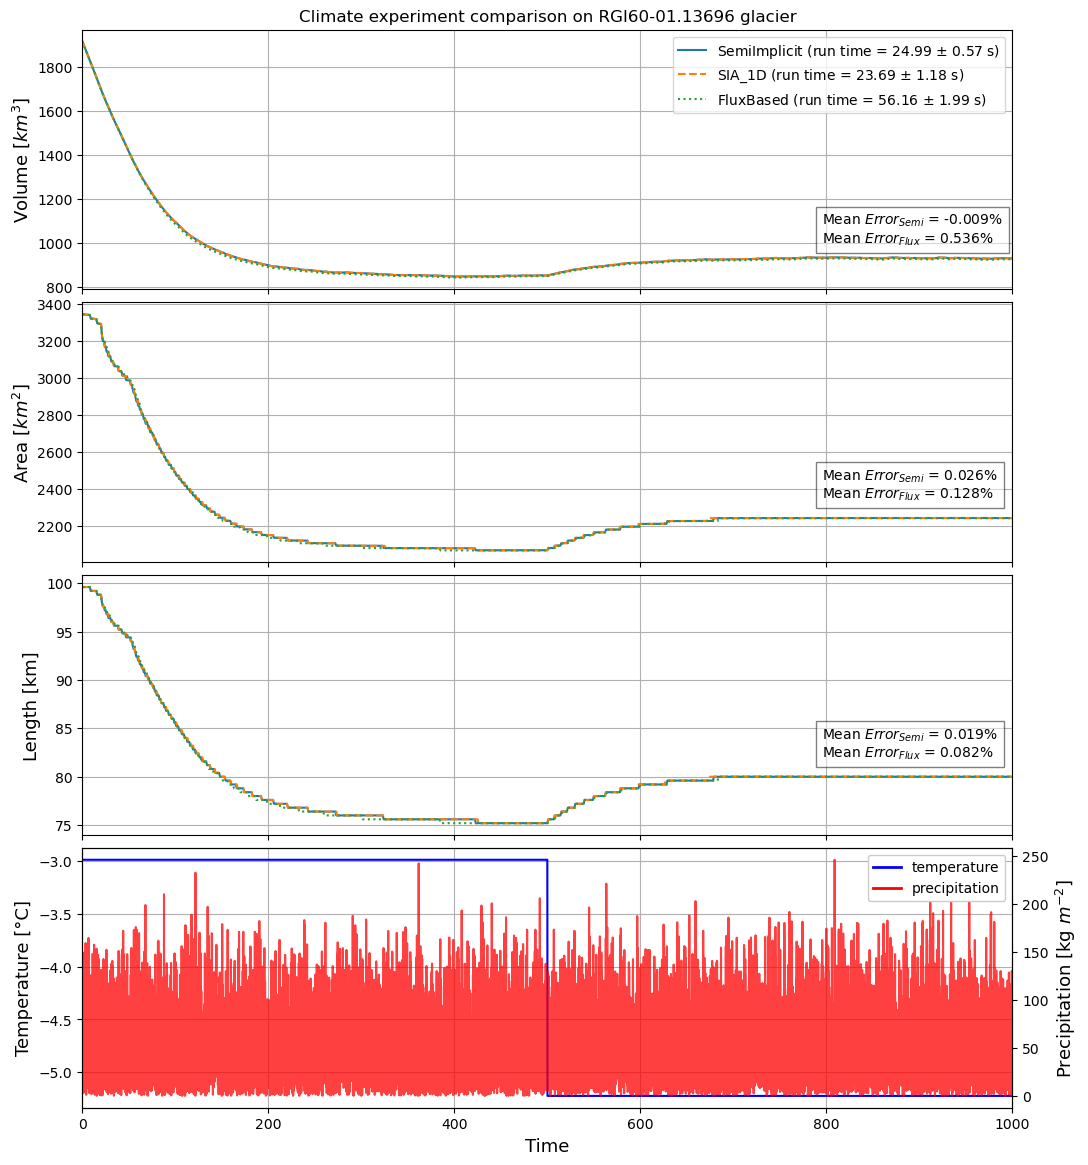

In [457]:
#Individual figure
from matplotlib.lines import Line2D
f, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(12, 14),sharex=True)
f.subplots_adjust(hspace=0.05)
gdir = gdirs[3]
    
    
ds = utils.compile_run_output(gdir, input_filesuffix='_SemiImplicit')
ds2 = utils.compile_run_output(gdir, input_filesuffix='_SIA1D')
ds3 = utils.compile_run_output(gdir, input_filesuffix='_FluxBased')

(ds.volume*1e-9).plot(ax=ax1,
label="SemiImplicit (run time = {} $\pm$ {} s)".format(round(num_mod_perf['SemiImplicit'][0],2),
                                                      round(num_mod_perf['SemiImplicit'][1],2)))   


                      
(ds2.volume*1e-9).plot(ax=ax1,linestyle="dashed",
 label="SIA_1D (run time = {} $\pm$ {} s)".format(round(num_mod_perf['SIA1D'][0],2),
                                                                round(num_mod_perf['SIA1D'][1],2)))


(ds3.volume*1e-9).plot(ax=ax1,linestyle=":",
label="FluxBased (run time = {} $\pm$ {} s)".format(round(num_mod_perf['FluxBased'][0],2),
                                                          round(num_mod_perf['FluxBased'][1],2)))
err_s = round(((ds2.volume-ds.volume)/ds.volume).mean().data*100,3)
err_f = round(((ds2.volume-ds3.volume)/ds3.volume).mean().data*100,3)
test='$Error_{Semi}$'
test2='$Error_{Flux}$'
ax1.text(1795,1000, 'Mean {} = {}% \nMean {} = {}%'.format(test,err_s,test2,err_f),
         fontsize = 10,bbox=dict(facecolor='white', alpha=0.5))


(ds.area*1e-6).plot(ax=ax2)
(ds2.area*1e-6).plot(ax=ax2,linestyle='dashed')
(ds3.area*1e-6).plot(ax=ax2,linestyle=':')
err_s = round(((ds2.area-ds.area)/ds.area).mean().data*100,3)
err_f = round(((ds2.area-ds3.area)/ds3.area).mean().data*100,3)
test='$Error_{Semi}$'
test2='$Error_{Flux}$'
ax2.text(1795, 2350, 'Mean {} = {}% \nMean {} = {}%'.format(test,err_s,test2,err_f),
         fontsize = 10,bbox=dict(facecolor='white', alpha=0.5))


"""
ax3.plot(ds.time.values,diag[0])
ax3.plot(ds.time.values,diag[2], linestyle='dashed')
ax3.plot(ds.time.values,diag[1], linestyle=':')

err_s = round(((np.array(diag[2])-np.array(diag[0]))/np.array(diag[0])).mean()*100,3)
err_f = round(((np.array(diag[2])-np.array(diag[1]))/np.array(diag[1])).mean()*100,3)
test='$Error_{Semi}$'
test2='$Error_{Flux}$'
ax3.text(1795,0, 'Mean {} = {}% \nMean {} = {}%'.format(test,err_s,test2,err_f),
         fontsize = 10,bbox=dict(facecolor='white', alpha=0.5))
"""



(ds.length*1e-3).plot(ax=ax3)
(ds2.length*1e-3).plot(ax=ax3,linestyle='dashed')
(ds3.length*1e-3).plot(ax=ax3,linestyle=':')
err_s = round(((ds2.length-ds.length)/ds.length).mean().data*100,3)
err_f = round(((ds2.length-ds3.length)/ds3.length).mean().data*100,3)
test='$Error_{Semi}$'
test2='$Error_{Flux}$'
ax3.text(1795, 82, 'Mean {} = {}% \nMean {} = {}%'.format(test,err_s,test2,err_f),
         fontsize = 10,bbox=dict(facecolor='white', alpha=0.5))

ax1.grid()
ax1.set_ylabel('Volume [$km^3$]',fontsize = 13)
ax1.set_xlabel('')
ax2.grid()
ax2.set_ylabel('Area [$km^2$]',fontsize = 13)
ax2.set_xlabel('')
ax2.set_title('')
ax3.grid()
ax3.set_ylabel('Length [km]',fontsize = 13)
ax3.set_title('')
ax1.legend(loc=1)
ax3.set_xlabel('')
#ax1.set_xlim([2020,2100])

ax1.set_title('Climate experiment comparison on {} glacier'.format(gdir.rgi_id))

ax4.set_xlabel('Time',fontsize = 13)
ax4.grid()
ax4.plot(date_final,ds_exp_list[3].temp.values[0],color='b')
ax4.set_ylabel('Temperature [°C]',fontsize = 13)
               
ax4b=ax4.twinx()
ax4b.plot(date_final,ds_exp_list[3].prcp.values[0], color='r',alpha=0.75)
ax4b.set_ylabel('Precipitation [kg $m^{-2}$]',fontsize = 13)
ax4.set_xlim([1000,2000])
tl = Line2D([0], [0], color='b', lw=2, label = 'temperature')
pl = Line2D([0], [0], color='r', lw=2, label = 'precipitation')

ax4b.legend(handles=[tl,pl], loc = 1, framealpha=1) 
ax4.set_xticklabels(['0','200','400','600','800','1000'])